In [1]:
import pandas as pd
from wordcloud import WordCloud as cloud
import matplotlib.pyplot as plt
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as stopwords
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer as lemm, SnowballStemmer as stemm
from nltk.stem.porter import *
from nltk.corpus import stopwords
import en_core_web_lg
nlp =  en_core_web_lg.load()

stop_words = stopwords.words('english')
stop_words.extend(['reuters','cnbc','year','last','banks','first','one','two','billion','due','rose','next','global','end','investors','lower','risk','back', 'week','however','policy', 'editing', 'figures','currencies','coronavirus','analysts','interest',
                   'level','currency','economy','long','term','likely','reporting','resistance','central','bank', 'tuesday', 'friday', 'march','april','june','july','august','september','october','november','december','january','february','barely','enough',
                   'expected','ahead','data','writing','around','today','index','reported','price','prices','inflation', 'market','markets', 'month', 'could','rate','rates','time',
                   'info','said','would','may','since','also','support','new','higher','day','high','low','trade','trading','wednesday','thursday','monday','economic','calendar'])

stop_words.extend(['january','february','march','april','may','june','july','august','september','october','november','december','monday','tuesday',
                  'wednesday','thursday','friday','saturday','sunday','will','day','today','week','weeks','yesterday','tomorrow'])

import numpy as np
np.random.seed(0)
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis as pyldavis


from pymongo import MongoClient

connection=MongoClient("mongodb://localhost:27017/crawler.contents")

db=connection.get_database()

[nltk_data] Downloading package wordnet to /home/visnja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/visnja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [3]:

articles = pd.DataFrame(list(db.contents.find()))


articles = articles.drop(columns=['visited','created_at','contentType','date','icon','_id'])
articles.head()
articles = articles.dropna(how='any',axis=0)

import re

def clean(txt):
    excluded_tags = {"VERB", "ADV","ADJ","NUM","PRON","ADP","AUX","CCONJ","DET","INTJ","PART"}
    new_sentence = []
    for token in nlp(txt):
        if token.pos_ not in excluded_tags:
            new_sentence.append(token.text)
    res = " ".join(new_sentence)
    res = re.sub(r'[,\.!?]','',txt)
    res = str(res.lower())
    res = re.sub(r'\d* min read', '', str(res), flags=re.IGNORECASE)
    res = re.sub(r'by reuters staff', '', str(res), flags=re.IGNORECASE)
    res = re.sub(r'australian dollar', 'aud', str(res), flags=re.IGNORECASE)
    res = re.sub(r'us dollar', 'usd', str(res), flags=re.IGNORECASE)
    res = re.sub(r'british pound', 'gbp', str(res), flags=re.IGNORECASE)
    res = re.sub(r'canadian dollar', 'cad', str(res), flags=re.IGNORECASE)
    res = re.sub(r'euro ', 'eur ', str(res), flags=re.IGNORECASE)
#     new_sentence = []
#     for token in nlp(res):
#         if token.pos_ not in excluded_tags:
#             new_sentence.append(token.text)
    res = re.sub(r'[^\w\s]', '', res)
    res = re.sub(r'\d*', '', res)
    
#     res = re.sub(r'[^\d]', '', res)
#     lst_txt = res.split()
#     ps = nltk.stem.porter.PorterStemmer()
#     lst_txt = [ps.stem(word) for word in lst_txt]
#     lem = nltk.stem.wordnet.WordNetLemmatizer()
#     lst_txt = [lem.lemmatize(word) for word in lst_txt]
#     lst_txt = remove_stopwords(lst_txt)
#     txt = " ".join(txt)
    return res

articles['text_processed'] = articles['body'].map(lambda x: [clean(y)  if isinstance(x,list) else [] for y in list(x)])

articles['text_processed_join'] = articles['text_processed'].map(lambda x:  " ".join(x))
print(articles['text_processed_join'][0])

long_string = ','.join(list(articles['text_processed_join'].values))

  tokyo reuters  the aud and other riskier currencies recovered some lost ground against the usd on monday after suffering their biggest plunges in a year at the end of last week amid a hefty selloff in global bond markets the greenback weakened broadly early in asia trade but barely enough to trim its biggest surge since june from friday currency markets have taken cues from the global bond market where yields have surged in anticipation of an accelerated economic recovery the aggressive bond selling implies a bet that global central bankers will need to tighten policy much earlier than they have so far been forecasting equities and commodities have also sold off as the debt rout unsettles investors usd direction is likely to hinge on not only the direction but also the pace of global bond moves commonwealth bank of australia strategists wrote in a research note bond moves are trumping economic data as the driver of foreignexchange markets with yields moving well in advance of economi

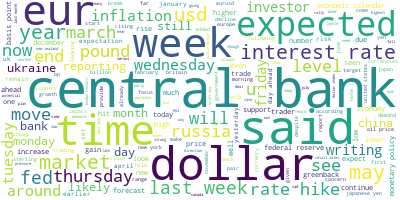

In [4]:
wordcloud = cloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [5]:
data = articles['text_processed_join'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['tokyo', 'aud', 'riskier', 'recovered', 'lost', 'ground', 'usd', 'suffering', 'biggest', 'plunges', 'amid', 'hefty', 'selloff', 'bond', 'greenback', 'weakened', 'broadly', 'early', 'asia', 'trim', 'biggest', 'surge', 'taken', 'cues', 'bond', 'yields', 'surged', 'anticipation', 'accelerated', 'recovery']


In [6]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 3), (15, 2), (16, 1), (17, 5), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [7]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"us" + 0.006*"dollar" + 0.004*"usd" + 0.004*"eur" + 0.003*"see" + '
  '0.003*"move" + 0.003*"fed" + 0.003*"yen" + 0.003*"oil" + 0.002*"near"'),
 (1,
  '0.012*"us" + 0.006*"dollar" + 0.006*"fed" + 0.004*"eur" + 0.004*"usd" + '
  '0.004*"yen" + 0.003*"yields" + 0.003*"growth" + 0.003*"pound" + '
  '0.003*"still"'),
 (2,
  '0.007*"dollar" + 0.005*"us" + 0.004*"contracts" + 0.004*"traders" + '
  '0.004*"european" + 0.003*"eur" + 0.003*"chart" + 0.003*"growth" + '
  '0.003*"usd" + 0.003*"net"'),
 (3,
  '0.008*"dollar" + 0.007*"us" + 0.004*"eur" + 0.003*"usd" + 0.003*"fed" + '
  '0.003*"fell" + 0.003*"pound" + 0.003*"oil" + 0.003*"yen" + 0.002*"ukraine"'),
 (4,
  '0.010*"us" + 0.007*"dollar" + 0.005*"eur" + 0.005*"fed" + 0.004*"traders" + '
  '0.003*"russia" + 0.003*"move" + 0.003*"financial" + 0.002*"usd" + '
  '0.002*"reserve"'),
 (5,
  '0.009*"us" + 0.009*"dollar" + 0.006*"eur" + 0.004*"pound" + 0.004*"usd" + '
  '0.003*"monetary" + 0.003*"move" + 0.003*"fed" + 0.003*"yen" +

In [8]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/01ldavis_prepared_'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)


/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [9]:
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)


In [10]:
 pyLDAvis.save_html(LDAvis_prepared, './results/01ldavis_prepared_'+ str(num_topics) +'.html')

/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-